In [120]:
import pandas as pd
import numpy as np
import scipy as sp
import altair as alt
alt.renderers.enable('notebook')
alt.themes.enable('opaque')

alt.data_transformers.disable_max_rows()
df_train = pd.read_csv('../data/raw/train_lofi_rowid_Nov13.csv')
df_test = pd.read_csv('../data/raw/test_lofi_rowid_Nov13.csv')

df_train.head()

,row_id,well_id,GR,label
0,0,0,99.005617,0
1,1,0,105.563944,0
2,2,0,105.921065,0
3,3,0,113.513354,0
4,4,0,101.523783,0


## Figure out if the depth reference point is common, or tied to surface.
1. Looks like the reference is not globally defined, i.e. the 0 depth is at surface. :(
2. The wells have a consistent length (all have 1100 points). So maybe the geological model is flat-surfaced..?


In [121]:
df_train.groupby('well_id').size().describe()

count    4000.0
mean     1100.0
std         0.0
min      1100.0
25%      1100.0
50%      1100.0
75%      1100.0
max      1100.0
dtype: float64

Lets plot a few wells with close `well_id` together in a section

/home/anton/miniconda3/envs/pg_model/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


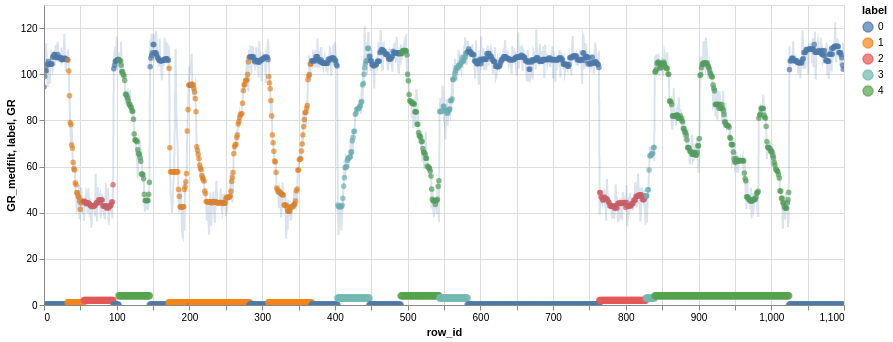

In [132]:
h=300
well_ids = df_train['well_id'].unique()[0]
df_sub = df_train[df_train['well_id'] == well_ids]
df_sub['GR_medfilt'] = medfilt(df_sub['GR'],11)
ch_gr = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point().interactive()
ch_line = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='GR',order='row_id').mark_line(opacity=0.2)
ch_gr + ch_lab + ch_line

In [71]:
df_train['grdiff'] = df_train['GR'].diff()
alt.Chart(data=df_train).encode(x='grdiff',y='count()').mark_bar()

KeyboardInterrupt: 

# Try playing with KDTree

In [67]:
from scipy.signal import medfilt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from scipy.stats import mode

def cut_window(data_cycle, overlap=0.0, base_length=96):
    """
    Function for fancy numpy indexing
    :param data_cycle:
    :type data_cycle:
    :param overlap:
    :type overlap:
    :param base_length:
    :type base_length:
    :return:
    :rtype:
    """
    step = int((1 - overlap) * base_length)
    n_windows = np.ceil((data_cycle.shape[0] - base_length) / step)
    indexer = np.arange(base_length)[None, :] + step * np.arange(n_windows)[:, None]
    return indexer.astype('int'), int(n_windows)

def get_a_NN_object(df, n_wells_start, n_wells_end=2000, window_length=45):
    df['GR_medfilt'] = medfilt(df['GR'], 31)
    well_ids = df['well_id'].unique().tolist()[n_wells_start:(n_wells_start + n_wells_end)]
    df_wells = df[df['well_id'].isin(well_ids)]
    idxr, n_wins = cut_window(df_wells['GR_medfilt'], overlap=0.8, base_length=window_length)
    windows = df_wells['GR_medfilt'].values[idxr]
    labels = df_wells['label'].values[idxr]
    NN = NearestNeighbors(n_neighbors=10, metric='braycurtis')
    NN.fit(windows)
    return NN, labels


def augment_a_well_nearest_neighbors(df, NN, labels, bl=40):
    df_tmp = df.copy()
    df_tmp['GR_nn'] = medfilt(df['GR'], 31)
    idxr, n_win = cut_window(df_tmp['GR_nn'].values, overlap=0.0, base_length=bl)
    windows = df_tmp['GR_nn'].values[idxr]
    dist, idw = NN.kneighbors(windows, n_neighbors=5)
    dist_flip, idw_flip = NN.kneighbors(np.fliplr(windows), n_neighbors=5)

    pred = mode(labels[idw, :], axis=1)[0]
    pred = pred.reshape(pred.shape[0], pred.shape[2]).flatten()

    pred_lr = mode(labels[idw_flip, :], axis=1)[0]
    pred_lr = pred_lr.reshape(pred_lr.shape[0], pred_lr.shape[2])

    df_labels_windows = pd.DataFrame(
        {'row_id': idxr.flatten(), f'label_nn_{bl}': pred, f'flip_same_{bl}': np.equal(pred, pred_lr.flatten()),
         f'same_after_inv_{bl}': np.equal(pred, np.fliplr(pred_lr).flatten())})
    res = df_labels_windows.groupby('row_id').mean().reset_index()
    res = df_tmp.join(res, on='row_id', rsuffix='_r').drop(columns=['row_id_r', 'GR_nn'])
    return res

df_train['GR_medfilt'] = medfilt(df_train['GR'],31)
window_length = 35

wells_test = df_train['well_id'].unique()[3900:3950]
df_wells_test =  df_train[df_train['well_id'].isin(wells_test)]
NN_list,labels_list = [],[]
NN, labels = get_a_NN_object(df_train,n_wells_start=0,n_wells_end=400,window_length=window_length)


df_wells_test_dict  = dict(zip(wells_test,[df_train[df_train['well_id'] ==w] for w in wells_test]))
df_wells_test_augmented =[augment_a_well_nearest_neighbors(df,NN,labels,bl=window_length) for df in df_wells_test_dict.values()]

In [68]:
df_all_test = pd.concat(df_wells_test_augmented,axis=0).dropna()
print(accuracy_score(df_all_test['label'],df_all_test[f'label_nn_{window_length}']))

0.8731981566820276


0.89096


[[   0    1    2 ...   32   33   34]
 [  35   36   37 ...   67   68   69]
 [  70   71   72 ...  102  103  104]
 ...
 [ 980  981  982 ... 1012 1013 1014]
 [1015 1016 1017 ... 1047 1048 1049]
 [1050 1051 1052 ... 1082 1083 1084]]
(31, 35)


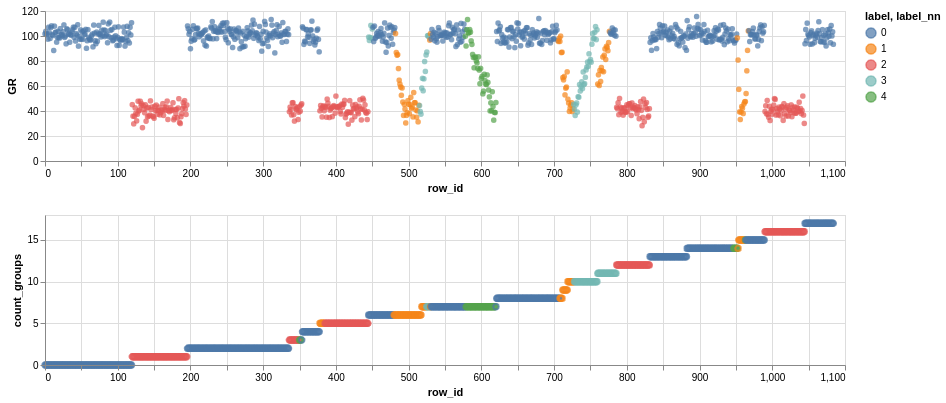

In [117]:
%matplotlib inline
tmp = df_train[df_train['well_id'].isin([17])]
def augment_a_well_nearest_neighbors(df,NN,labels,bl=50):
    from scipy.stats import mode
    idxr,n_win = cut_window(df['GR_medfilt'].values,overlap=0.0,base_length=bl)
    windows = df['GR_medfilt'].values[idxr]
    print(idxr)
    dist,idw = NN.kneighbors(windows,n_neighbors=5)
    pred =mode(labels[idw,:],axis=1)[0]
    pred = pred.reshape(pred.shape[0],pred.shape[2])
    print(pred.shape)
    #true_labels = df['label'].values[idxr].flatten()
    res=None
    df_labels_windows = pd.DataFrame({'row_id':idxr.flatten(),'label_nn':pred.flatten()})
    #df_labels_windows = df_labels_windows.groupby('row_id').mean().reset_index()
    res = df_labels_windows.groupby('row_id').mean().reset_index()
    res = df.copy().join(res,on='row_id',rsuffix='_r').drop(columns = 'row_id_r')
    return res


def divide_block_steps(df,t=24):
    df['step'] = (df['GR'].diff().abs() >= t)
    df_steps = df[df['step']]
    
    inds = np.hstack([0,np.array(df_steps['row_id']),df['row_id'].max()+1])
    counts = np.zeros(df.shape[0])
    counts[:inds[0]] = np.arange(inds[0])
    res = np.ones(df.shape[0])
    for i in range(len(inds) - 1):
        res[inds[i]:inds[i + 1]] = i
        counts[inds[i]:inds[i + 1]] = np.arange(inds[i + 1] - inds[i])
    
    df['prev_val_step'] = np.nan
    df.loc[df['step'],'prev_val_step'] = df['GR'].diff()
    df['prev_val_step'] = df['prev_val_step'].fillna(method = 'ffill').astype('float')
    
    df['next_val_step'] = np.nan
    df.loc[df['step'],'next_val_step'] = df['GR'].diff()
    df['next_val_step'] = df['next_val_step'].fillna(method ='bfill').astype('float')    
        
    df['count_step'] = counts
    df['count_groups'] = res
    df['count_step_norm'] = df['count_step']/df.groupby('count_groups')['count_step'].transform('max')
    
    return df

df_preds = augment_a_well_nearest_neighbors(tmp,NN,labels,bl=window_length).dropna()
df_preds['grp'] = (df_preds['label_nn']==df_preds['label_nn'].shift(1)).cumsum()
df_preds = divide_block_steps(df_preds,20)

ch_gr = alt.Chart(df_preds,height=150,width=800).encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_preds,height=150,width=800).encode(x='row_id',y='count_groups',order='row_id',color='label_nn:N').mark_point()
#ch_steps = alt.Chart(df_steps,height=150,width=800).encode(x='row_id').mark_rule()

(ch_gr) & (ch_lab)

In [72]:
df_preds

,row_id,well_id,GR,label,GR_medfilt,label_nn,grp
3630000,0,3300,120.201097,0,109.949728,0.0,0
3630001,1,3300,117.084173,0,109.949728,0.0,1
3630002,2,3300,114.449990,0,109.949728,0.0,2
3630003,3,3300,120.566324,0,109.949728,0.0,3
3630004,4,3300,117.823130,0,109.949728,0.0,4
3630005,5,3300,110.795737,0,109.949728,0.0,5
3630006,6,3300,117.546991,0,109.949728,0.0,6
3630007,7,3300,119.440709,0,109.949728,0.0,7
3630008,8,3300,119.675761,0,109.949728,0.0,8
3630009,9,3300,116.536417,0,109.949728,0.0,9


# Prototype a few functions:

In [6]:
from sklearn.linear_model import LinearRegression
def diff_sum(x):
    res = np.diff(x).sum()
    return res
def abs_diff_sum(x):
    res = np.abs(np.diff(x)).sum()
    return res

def rolling_slope(x):
    model_ols =LinearRegression()
    idx=np.arange(x.shape[0])
    model_ols.fit(idx.reshape(-1, 1), x.reshape(-1, 1))
    res = model_ols.coef_[0]
    return res

    
def apply_rolling_functions(df,col='GR',window=10,func ={'mean':np.mean,'std':np.std,'diff_sum':diff_sum,'abs_diff_sum':abs_diff_sum,'slope':rolling_slope}):
    names =[]
    for k,v in func.items():
        series = df[col].rolling(window=window,center=True,min_periods=1).apply(v,raw=True)
        colname = f'{k}_{window}_{col}'
        df.loc[:,colname] = series.values
        names.append(colname)
    df.index = np.arange(df.shape[0])
    return df[names]
def preprocess_a_well(df_well):
    df_feats_w20 = apply_rolling_functions(df_well,window=20)
    df_feats_w60 = apply_rolling_functions(df_well,window=60)
    df_feats_w150 = apply_rolling_functions(df_well,window=150)
    df_feats = pd.concat([df_well,df_feats_w20,df_feats_w60,df_feats_w150],axis=1)
    return df_feats
